# A. Perkenalan

**============================================================================================================** <br>
-- *Graded Challenge 7* --<br>

Nama: Teguh Sukmanaputra <br>
Batch: RMT-029 <br>

Program ini merupakan sebuah computer vision yang akan mendeteksi dan memprediksi klasifikasi sebuah gambar yang menunjukkan kegiatan "Smoking" atau "Not-Smoking".
**============================================================================================================**

# B. Import Libraries

In [1]:
# Libraries

import os
import glob
import cv2
import shutil # file operation tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path

!pip install kaggle
from google.colab import files

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# C. Data Loading

## C.1 Data Preparation

In [2]:
# Load Data from Kaggle to directory

files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sujaykapadnis/smoking
!unzip -q /content/smoking.zip

Saving kaggle.json to kaggle.json
 88% 56.0M/63.8M [00:00<00:00, 83.0MB/s]
100% 63.8M/63.8M [00:00<00:00, 91.3MB/s]


In [3]:
# Labeling File

# Getting the file paths
train_files = glob.glob('/content/Training/Training/*')

# Define labels from file paths
labels = []
for file_path in train_files:
    file_name = os.path.basename(file_path)
    if "smoking" in file_name.lower() and "notsmoking" not in file_name.lower(): # memisahkan label file secara spesifik
        labels.append("smoking")
    else:
        labels.append("not-smoking")

In [4]:
# Extract image sizes

image_sizes = []
image_sizes_kb = []
for file_path in train_files:
    # Read the image and get its size
    img = cv2.imread(file_path)

    # Get the image height and width
    height, width, _ = img.shape
    image_sizes.append((height, width))

    # Get the image file size in bytes
    file_size_bytes = os.path.getsize(file_path)
    file_size_kb = file_size_bytes / (1024.0) # Convert file size to kilobytes (KB)
    image_sizes_kb.append(file_size_kb)

In [5]:
# Create DataFrame

df_train_file = pd.DataFrame({'file_path': train_files, 'label': labels, 'image_size': image_sizes, 'image_size_kb': image_sizes_kb})
df_train_file

,file_path,label,image_size,image_size_kb
0,/content/Training/Training/smoking_0044.jpg,smoking,"(250, 250)",52.616211
1,/content/Training/Training/notsmoking_0152.jpg,not-smoking,"(250, 250)",47.831055
2,/content/Training/Training/smoking_0140.jpg,smoking,"(250, 250)",99.031250
3,/content/Training/Training/notsmoking_0099.jpg,not-smoking,"(250, 250)",125.942383
4,/content/Training/Training/smoking_0130.jpg,smoking,"(250, 250)",68.315430
...,...,...,...,...
711,/content/Training/Training/smoking_0143.jpg,smoking,"(250, 250)",83.792969
712,/content/Training/Training/smoking_0099.jpg,smoking,"(250, 250)",89.297852
713,/content/Training/Training/smoking_0186.jpg,smoking,"(250, 250)",104.816406
714,/content/Training/Training/smoking_0135.jpg,smoking,"(250, 250)",86.095703


Diperoleh DataFrame yang berisikan alamat data gambar beserta label, ukuran gambar, dan besar ukuran file gambar tersebut dalam kilobyte. Adapun DataFrame ini nantinya dapat digunakan untuk exploratory data analysis.

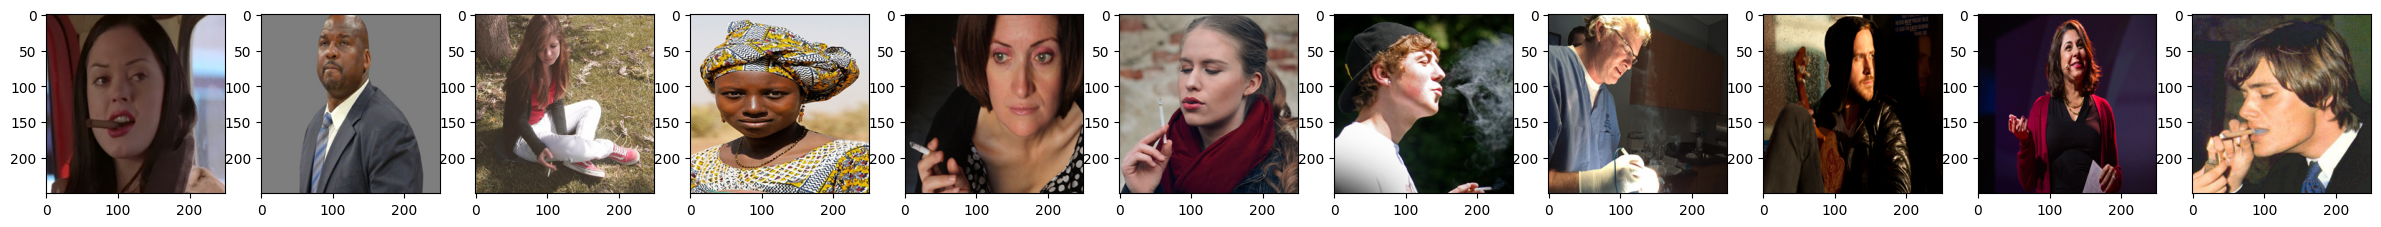

In [6]:
# Show images preview

fig, ax = plt.subplots(ncols=11, figsize=(30,3))
for i in range(11):
  train_images = plt.imread(train_files[i])
  ax[i].imshow(train_images)

## C.2 Loading Image Data in Tensorflow

### C.2.1 Creating Data Directories

In [6]:
# Separate and move image files into different folder

# Define the path to your main directory containing all images
train_images_directory = '/content/Training/Training'

# Create one main file that consist of two subdirectories
train_main_directory = '/content/Training'
main_subfile = os.path.join(train_main_directory, 'train_set')

# Create two subdirectories: one for smoking images and one for non-smoking images
smoking_directory = os.path.join(main_subfile, 'smoking')
not_smoking_directory = os.path.join(main_subfile, 'not_smoking')

# Create the subdirectories if they don't exist
os.makedirs(smoking_directory, exist_ok=True)
os.makedirs(not_smoking_directory, exist_ok=True)

# Get a list of all image file names in the main directory
all_images = os.listdir(train_images_directory)

# Loop through each image file and move it to the appropriate subdirectory
for image_name in all_images:
    if 'smoking' in image_name.lower() and "notsmoking" not in image_name.lower():
        shutil.copy(os.path.join(train_images_directory, image_name), os.path.join(smoking_directory, image_name))
    else:
        shutil.copy(os.path.join(train_images_directory, image_name), os.path.join(not_smoking_directory, image_name))

print("Images have been copied to separate subdirectories.")

Images have been copied to separate subdirectories.


In [7]:
# Separate and move image files into different folder

# Define the path to your main directory containing all images
val_images_directory = '/content/Validation/Validation'

# Create one main file that consist of two subdirectories
val_main_directory = '/content/Validation'
main_subfile = os.path.join(val_main_directory, 'val_set')

# Create two subdirectories: one for smoking images and one for non-smoking images
smoking_directory = os.path.join(main_subfile, 'smoking')
not_smoking_directory = os.path.join(main_subfile, 'not_smoking')

# Create the subdirectories if they don't exist
os.makedirs(smoking_directory, exist_ok=True)
os.makedirs(not_smoking_directory, exist_ok=True)

# Get a list of all image file names in the main directory
all_images = os.listdir(val_images_directory)

# Loop through each image file and move it to the appropriate subdirectory
for image_name in all_images:
    if 'smoking' in image_name.lower() and "notsmoking" not in image_name.lower():
        shutil.copy(os.path.join(val_images_directory, image_name), os.path.join(smoking_directory, image_name))
    else:
        shutil.copy(os.path.join(val_images_directory, image_name), os.path.join(not_smoking_directory, image_name))

print("Images have been copied to separate subdirectories.")

Images have been copied to separate subdirectories.


In [8]:
# Separate and move image files into different folder

# Define the path to your main directory containing all images
test_images_directory = '/content/Testing/Testing'

# Create one main file that consist of two subdirectories
test_main_directory = '/content/Testing'
main_subfile = os.path.join(test_main_directory, 'test_set')

# Create two subdirectories: one for smoking images and one for non-smoking images
smoking_directory = os.path.join(main_subfile, 'smoking')
not_smoking_directory = os.path.join(main_subfile, 'not_smoking')

# Create the subdirectories if they don't exist
os.makedirs(smoking_directory, exist_ok=True)
os.makedirs(not_smoking_directory, exist_ok=True)

# Get a list of all image file names in the main directory
all_images = os.listdir(test_images_directory)

# Loop through each image file and move it to the appropriate subdirectory
for image_name in all_images:
    if 'smoking' in image_name.lower() and "notsmoking" not in image_name.lower():
        shutil.copy(os.path.join(test_images_directory, image_name), os.path.join(smoking_directory, image_name))
    else:
        shutil.copy(os.path.join(test_images_directory, image_name), os.path.join(not_smoking_directory, image_name))

print("Images have been copied to separate subdirectories.")

Images have been copied to separate subdirectories.


In [9]:
# Define data directories
train_dir = '/content/Training/train_set'
val_dir = '/content/Validation/val_set'
test_dir = '/content/Testing/test_set'

### C.2.2 Train Set

In [10]:
# Generates batches of augmented data from a directory

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(250, 250),
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    shuffle=False)

Found 716 images belonging to 2 classes.


In [11]:
# Show data type of variable `train_generator`

train_generator

In [12]:
# Index of category

train_generator.class_indices

{'not_smoking': 0, 'smoking': 1}

### C.2.3 Validation Set

In [13]:
# Generates batches of augmented data from a directory

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(250, 250),
                                                batch_size=32,
                                                class_mode='binary',
                                                shuffle=False)

Found 180 images belonging to 2 classes.


In [14]:
# Index of category

val_generator.class_indices

{'not_smoking': 0, 'smoking': 1}

### C.2.4 Test Set

In [15]:
# Generates batches of augmented data from a directory

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = val_datagen.flow_from_directory(test_dir,
                                                 target_size=(250, 250),
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 shuffle=False)

Found 224 images belonging to 2 classes.


# D. Exploratory Data Analysis (EDA)

Sebelumnya, telah dibuat sebuah DataFrame yang berisikan alamat data gambar beserta label, ukuran gambar, dan besar ukuran file gambar tersebut dalam kilobyte.

In [6]:
# Train DataFrame

df_train_file

,file_path,label,image_size,image_size_kb
0,/content/Training/Training/smoking_0044.jpg,smoking,"(250, 250)",52.616211
1,/content/Training/Training/notsmoking_0152.jpg,not-smoking,"(250, 250)",47.831055
2,/content/Training/Training/smoking_0140.jpg,smoking,"(250, 250)",99.031250
3,/content/Training/Training/notsmoking_0099.jpg,not-smoking,"(250, 250)",125.942383
4,/content/Training/Training/smoking_0130.jpg,smoking,"(250, 250)",68.315430
...,...,...,...,...
711,/content/Training/Training/smoking_0143.jpg,smoking,"(250, 250)",83.792969
712,/content/Training/Training/smoking_0099.jpg,smoking,"(250, 250)",89.297852
713,/content/Training/Training/smoking_0186.jpg,smoking,"(250, 250)",104.816406
714,/content/Training/Training/smoking_0135.jpg,smoking,"(250, 250)",86.095703


In [22]:
# Save DataFrame into CSV

df_train_file.to_csv("df_train_images_file.csv")

## D.1 Class Data Proportion

In [8]:
df_train_file['label'].value_counts()

label
smoking        358
not-smoking    358
Name: count, dtype: int64

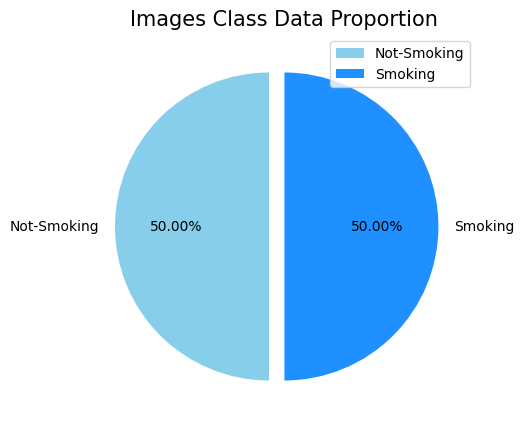

In [12]:
# Data class proportion

# Pie chart
labels = ['Not-Smoking', 'Smoking']
size = df_train_file['label'].value_counts()
colors = ['skyblue', 'dodgerblue']
explode = [0.1, 0]

fig, axes = plt.subplots(figsize=(10, 5))
plt.pie(size, colors = colors, explode = explode,
        labels = labels, startangle = 90, autopct = '%.2f%%')
plt.title('Images Class Data Proportion', fontsize = 15)
plt.legend()
plt.show()

Dapat diketahui bahwa proporsi data kelas pada dataset ini seimbang antara Smoking dan Not-Smoking dengan lebih spesifiknya yaitu terdiri dari 385 data gambar untuk masing-masing klasifikasinya. Sehingga tidak perlu mengkhawatirkan adanya penurunan performa akibat data imbalance.

## D.2 Images Size Comparison

In [18]:
# Calculate the average images size value
average_images_sizes = df_train_file.groupby('label')['image_size_kb'].mean()

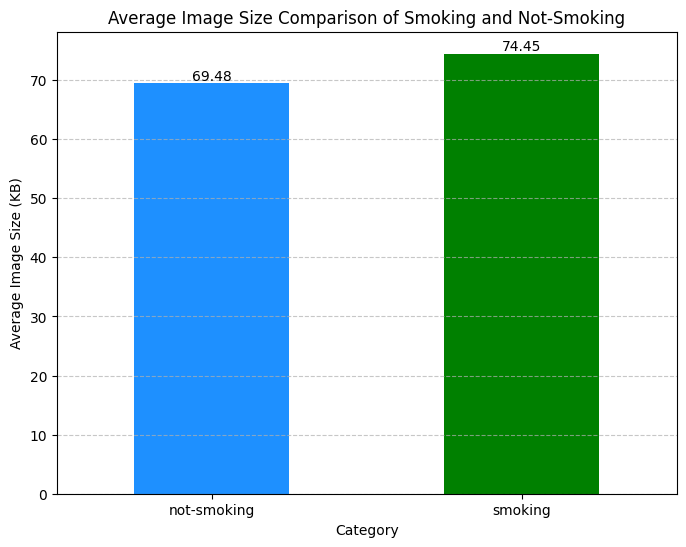

In [19]:
# Create histogram

plt.figure(figsize=(8, 6))
average_images_sizes.plot(kind='bar', color=['dodgerblue', 'green'])

# Add labels on top of each bar
for index, value in enumerate(average_images_sizes):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

plt.title('Average Image Size Comparison of Smoking and Not-Smoking')
plt.xlabel('Category')
plt.ylabel('Average Image Size (KB)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [21]:
# Average all images size
average_all_images_sizes = df_train_file['image_size_kb'].mean()
average_all_images_sizes

71.96432955438199

Dapat diketahui bahwa data gambar untuk kategori Smoking memiliki rerata ukuran file yang sedikit lebih besar yaitu sekitar 74kb dibandingkan kategori Not-Smoking yaitu sekitar 69kb. Hal ini mungkin dikarenakan pada gambar katergori Smoking lebih banyak ditemukan detail seperti asap rokok. Kemudian, secar keseluruhan rerata ukuran file gambar yang ada pada dataset ini berkisar pada 72kb, adapun besar rerata ukuran file gambar tersebut memang tidak terlalu besar namun sepertinya dapat membuat waktu training cukup lama apabila tidak menggunakan GPU.

# E. Feature Engineering

-

# F. ANN Training

## F.1 Model Definition

In [16]:
# Build the CNN model

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')])

In [17]:
# Model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 29, 29, 128)       0

In [18]:
# Compile the model

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## F.2 Model Training

In [19]:
# Train the model

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // 32, # calculated by dividing the total number of samples in the training dataset by 32
                    epochs=25,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // 32)

Epoch 1/25
22/22 [==============================] - 11s 164ms/step - loss: 0.7107 - accuracy: 0.4956 - val_loss: 0.6945 - val_accuracy: 0.4375
Epoch 2/25
22/22 [==============================] - 3s 134ms/step - loss: 0.6942 - accuracy: 0.5117 - val_loss: 0.6954 - val_accuracy: 0.4375
Epoch 3/25
22/22 [==============================] - 3s 120ms/step - loss: 0.6997 - accuracy: 0.4915 - val_loss: 0.6950 - val_accuracy: 0.4375
Epoch 4/25
22/22 [==============================] - 2s 110ms/step - loss: 0.6927 - accuracy: 0.4766 - val_loss: 0.6916 - val_accuracy: 0.4375
Epoch 5/25
22/22 [==============================] - 2s 107ms/step - loss: 0.6865 - accuracy: 0.5512 - val_loss: 0.6707 - val_accuracy: 0.6500
Epoch 6/25
22/22 [==============================] - 3s 150ms/step - loss: 0.6762 - accuracy: 0.5848 - val_loss: 0.6562 - val_accuracy: 0.6562
Epoch 7/25
22/22 [==============================] - 2s 112ms/step - loss: 0.6658 - accuracy: 0.6096 - val_loss: 0.5984 - val_accuracy: 0.6625
Epoch

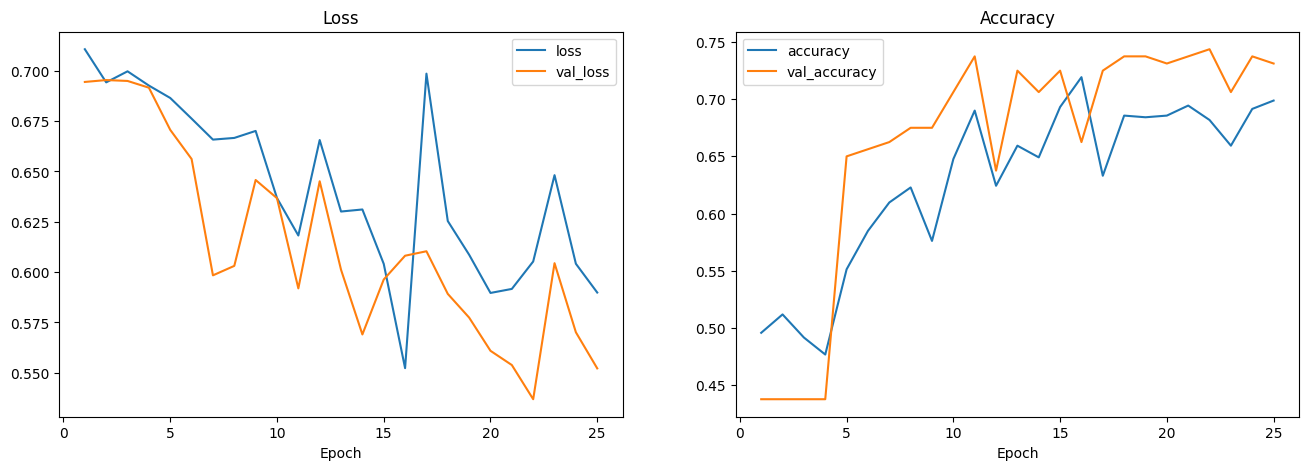

In [20]:
# Evaluation plot

epoch=25

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

Berdasarkan grafik diatas, dapat diketahui bahwa secara keseluruhan model yang dibangun tergolong dalam kategori goodfit dengan akurasi prediksi pada data validation sebesae 73%, namun banyak dan tingginya spike pada grafik diatas juga menunjukkan bahwa performa model kurang stabil. Oleh karena itu, berikutnya akan dilakukan optimisasi pada model ini.

## F.3 Model Optimizing

In [21]:
# Define data generators with data augmentation
train_optimize_datagen = ImageDataGenerator(rescale=1./255,
                                            rotation_range=20,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            shear_range=0.2,
                                            zoom_range=0.2,
                                            horizontal_flip=True)

train_optimize_generator = train_datagen.flow_from_directory(train_dir,
                                                             target_size=(250, 250),
                                                             batch_size=32,
                                                             class_mode='binary',
                                                             shuffle=False)

Found 716 images belonging to 2 classes.


In [24]:
# Build the model
model_optimize = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')])

In [27]:
# Compile the model
model_optimize.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [28]:
# Train the model
history = model_optimize.fit(train_generator,
                             steps_per_epoch=train_generator.samples // 32,
                             epochs=25,
                             validation_data=val_generator,
                             validation_steps=val_generator.samples // 32)

Epoch 1/25
22/22 [==============================] - 6s 118ms/step - loss: 0.7003 - accuracy: 0.4766 - val_loss: 0.6835 - val_accuracy: 0.5625
Epoch 2/25
22/22 [==============================] - 3s 118ms/step - loss: 0.6975 - accuracy: 0.3216 - val_loss: 0.6926 - val_accuracy: 0.7375
Epoch 3/25
22/22 [==============================] - 3s 142ms/step - loss: 0.6966 - accuracy: 0.4912 - val_loss: 0.6886 - val_accuracy: 0.5625
Epoch 4/25
22/22 [==============================] - 3s 112ms/step - loss: 0.6918 - accuracy: 0.5351 - val_loss: 0.6890 - val_accuracy: 0.6750
Epoch 5/25
22/22 [==============================] - 3s 117ms/step - loss: 0.6814 - accuracy: 0.6257 - val_loss: 0.6594 - val_accuracy: 0.6938
Epoch 6/25
22/22 [==============================] - 3s 144ms/step - loss: 0.6828 - accuracy: 0.6082 - val_loss: 0.6554 - val_accuracy: 0.6625
Epoch 7/25
22/22 [==============================] - 3s 118ms/step - loss: 0.6707 - accuracy: 0.5950 - val_loss: 0.6451 - val_accuracy: 0.6750
Epoch 

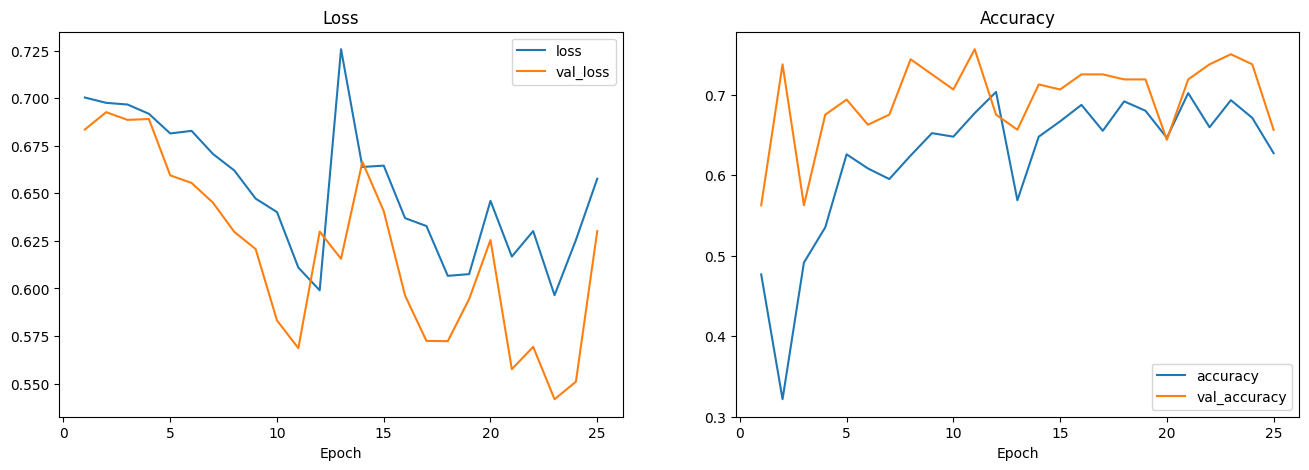

In [29]:
# Evaluation plot

epoch=25

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

Setelah dilakukan optimasi, tidak terdapat adanya kenaikan akurasi pada model, namun pada grafik diatas dapat terlihat bahwa performa model menjadi lebih stabil dan juga masih tergolong goodfit.

## F.4 Model Evaluation

In [31]:
# Evaluate the model on the testing dataset
test_loss, test_accuracy = model.evaluate(test_generator,
                                          steps=test_generator.samples // 32)

print("Test Accuracy:", test_accuracy)

7/7 [==============================] - 1s 77ms/step - loss: 0.6024 - accuracy: 0.7009
Test Accuracy: 0.7008928656578064


In [30]:
# Evaluate the model on the testing dataset
test_loss, test_accuracy = model_optimize.evaluate(test_generator,
                                          steps=test_generator.samples // 32)

print("Test Accuracy:", test_accuracy)

7/7 [==============================] - 1s 89ms/step - loss: 0.6431 - accuracy: 0.6116
Test Accuracy: 0.6116071343421936


Pada bagian evaluasi ini, dilakukan perbandingan evaluasi model sebelum dan setelah optimasi yang diujikan performanya pada data test. Berdasarkan perolehan kedua model ini, dapat terlihat bahwa model sebelum optimasi memiliki akurasi prediksi yang lebih tinggi yaitu 70% dibandingkan setelah optimasi yaitu 61%. Namun, mengingat bahwa performa model setelah optimasi yang lebih stabil maka model yang dipilih untuk disimpan adalah model setelah optimasi.

# G. Model Saving

In [32]:
# Save the model
model_optimize.save("/content/CNN_smoking_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
# Save the model
model_optimize.save("/content/CNN_smoking_model.keras")

# H. Model Inference

Terdapat pada file terpisah

# I. Kesimpulan

- Secara keseluruhan, model yang dibangun ini memiliki performa akurasi prediksi yang belum memuaskan yaitu sekitar 70% pada model tanpa optimasi dan sekitar 61% pada model yang dioptimasi ketika diujikan dengan test-set. Namun, meskipun performa akurasi model yang dibangun belum memuaskan, model memiliki performa yang tergolong Goodfit serta tetap dapat memprediksi dengan cukup baik ketika diujikan pada model inference.

- Model yang disimpan adalah model yang dioptimasi. Meskipun memiliki nilai performa akurasi yang lebih rendah dibandingkan model tanpa optimasi, performa prediksi model yang dioptimasi lebih stabil sehingga dipilih untuk disimpan.

- Menurut saya, performa akurasi model ini masih dapat ditingkatkan lagi dengan melakukan kembali pengaturan preprocessing gambar pada training model.